# Model Training and Evaluation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from dotenv import load_dotenv
import os

from neo4j import GraphDatabase

from sklearn.model_selection import train_test_split

from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from fancyimpute import IterativeImputer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import TomekLinks
from imblearn.combine import SMOTETomek

from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import RFECV
from skrebate import ReliefF
from collections import Counter

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
import optuna

from sklearn.model_selection import StratifiedKFold

from IPython.display import clear_output
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Connecting to Neo4j

def connect_to_neo4j(path):
    
    load_dotenv(path)

    uri = os.getenv("NEO4J_URI")
    user = os.getenv("NEO4J_USER")
    password = os.getenv("NEO4J_PASSWORD")

    # Creating a Neo4j Driver Instance
    driver = GraphDatabase.driver(uri, auth=(user, password))

    # Verifying Connection
    try:
        driver.verify_connectivity()
        print('Connected to database successfully.')
        return driver
    
    except Exception as err:
        print(f"Error: {err}, type: {type(err)}")

In [4]:
path = '../KG/db.env'

driver = connect_to_neo4j(path)

Connected to database successfully.


In [5]:
# Define a function to retrieve data from the knowledge graph based on suitable cypher queries 

def retrieve_data_from_graph(query):
    
    result_data = []

    with driver.session() as session:
        result = session.run(query)

        for record in result:
            result_data.append(dict(record))
    
    return result_data

In [6]:
# Function to retrieve all the data for a particular disease

def get_data_of_disease(disease):
    
    # Retrieve data for a specific disease from the knowledge graph.

    # Parameters:
    #     disease_name (str): The name of the disease to retrieve data for.

    # Returns:
    #     disease_df (pd.DataFrame): DataFrame containing person, disease, biomarker, and protein data.
    
    disease_query = """
    MATCH (p:Person)-[s:SUFFERS_FROM]->(d:Disease)
    where d.name = '"""+ disease +"""' and s.status IN ['Positive','Negative']
    RETURN p.respondentId as Respondent_ID,
    d.name AS DiseaseName,
    s.status AS DiseaseStatus;
    """

    disease_df = pd.DataFrame(retrieve_data_from_graph(disease_query))
    disease_data = disease_df.pivot(index=['Respondent_ID'],columns='DiseaseName', values='DiseaseStatus')
    disease_data = disease_data.reset_index()
    disease_data[disease] = disease_data[disease].map({'Negative': 0, 'Positive' : 1})

    biomarker_query = """
    MATCH (p:Person)-[s:SUFFERS_FROM]->(d:Disease)
    where d.name = '"""+ disease +"""' and s.status IN ['Positive','Negative']
    MATCH (p)-[h:HAS]->(b:BloodBiomarker)
    RETURN p.respondentId as Respondent_ID,
    p.gender AS Gender,
    p.age AS Age,
    p.bmi AS BMI,
    b.name AS BiomarkerName,
    b.unit AS BiomarkerUnit,
    h.value AS BiomarkerValue;
    """

    biomarker_df = pd.DataFrame(retrieve_data_from_graph(biomarker_query))
    biomarker_df['BloodBiomarker'] = np.where(biomarker_df['BiomarkerUnit'].notnull(),
                                       biomarker_df['BiomarkerName'] + ' [' + biomarker_df['BiomarkerUnit'] + ']',
                                       biomarker_df['BiomarkerName'])
    biomarker_data = biomarker_df.pivot(index=['Respondent_ID','Gender','Age','BMI'], 
                                        columns='BloodBiomarker',
                                        values='BiomarkerValue')
    biomarker_data = biomarker_data.reset_index()
    biomarker_data['Gender'] = biomarker_data['Gender'].map({'Female': 0, 'Male' : 1})


    protein_query = """
    MATCH (p:Person)-[s:SUFFERS_FROM]->(d:Disease)
    where d.name = '"""+ disease +"""' and s.status IN ['Positive','Negative']
    MATCH (p)-[h:HAS]->(b:BloodProtein)
    RETURN p.respondentId as Respondent_ID,
    b.name AS ProteinName,
    b.unit AS ProteinUnit,
    h.value AS ProteinValue;
    """

    protein_df = pd.DataFrame(retrieve_data_from_graph(protein_query))
    protein_df['BloodProtein'] = np.where(protein_df['ProteinUnit'].notnull(),
                                       protein_df['ProteinName'] + ' [' + protein_df['ProteinUnit'] + ']',
                                       protein_df['ProteinName'])
    protein_data = protein_df.pivot(index=['Respondent_ID'], 
                                        columns='BloodProtein',
                                        values='ProteinValue')
    protein_data = protein_data.reset_index()

    disease_df = biomarker_data.merge(protein_data, on='Respondent_ID',how='inner')
    disease_df = disease_df.merge(disease_data, on='Respondent_ID',how='inner')
    
    return disease_df

# Diabetes

In [7]:
# Data for Diabetes

diabetes_df = get_data_of_disease('Diabetes')
diabetes_df

,Respondent_ID,Gender,Age,BMI,25-hydroxyvitamin D2 + D3 [nmol/L],A/G Ratio,Alpha-carotene [umol/L],Alpha-crypotoxanthin [umol/L],Alpha-tocopherol [umol/L],Basophils [%],...,Ferritin [ng/mL],Gamma Glutamyl Transferase [IU/L],Hemoglobin [g/dL],Insulin [pmol/L],LDL-Cholesterol(NIH2) [mmol/L],Lactate Dehydrogenase [IU/L],Transferrin Saturation [%],Transferrin receptor [nmol/L],Triglyceride [mmol/L],Diabetes
0,93703,0,2,17.5,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,93704,1,2,15.7,74.4,NaN,NaN,NaN,NaN,0.7,...,36.60,NaN,13.1,NaN,NaN,NaN,NaN,30.6,NaN,0
2,93705,0,66,31.7,89.9,1.517241,0.138,0.071,26.006,1.0,...,28.70,21.0,11.9,NaN,NaN,174.0,28.0,39.8,NaN,0
3,93706,1,18,21.5,53.8,1.629630,0.160,0.031,16.765,0.8,...,284.00,16.0,16.3,NaN,NaN,142.0,51.0,34.0,NaN,0
4,93707,1,13,18.1,58.2,1.857143,0.009,0.044,22.756,0.5,...,49.30,9.0,14.5,NaN,NaN,177.0,21.0,34.0,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8888,102952,0,70,20.0,82.7,1.846154,0.235,0.077,31.347,0.6,...,135.00,18.0,13.4,26.34,1.112,168.0,39.0,29.1,0.881,1
8889,102953,1,42,35.8,49.5,1.142857,0.106,0.080,21.873,0.6,...,120.00,28.0,15.5,NaN,NaN,136.0,20.0,28.6,NaN,0
8890,102954,0,41,26.1,50.5,1.500000,0.117,0.056,26.935,1.4,...,1.99,8.0,6.4,56.94,2.793,123.0,5.0,248.0,0.553,0
8891,102955,0,14,45.6,61.9,1.205882,0.031,0.079,17.856,0.9,...,11.40,16.0,11.4,NaN,NaN,158.0,5.0,57.7,NaN,0


In [8]:
diabetes_df.shape

(8893, 91)

## Pre-processing

In [8]:
# Seperate the attributes and labels

X = diabetes_df.drop(['Respondent_ID','Diabetes'],axis=1)
y = diabetes_df['Diabetes'].copy()

In [9]:
# Splitting the data into training and test sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)

In [10]:
imputer = SimpleImputer(strategy='mean')

imputer.fit(X_train)

imputer.statistics_     # contains the mean values for each attribute

array([4.94658420e-01, 3.59339331e+01, 2.66632902e+01, 6.69514656e+01,
       1.35202339e+00, 9.39828822e-02, 5.47632135e-02, 2.65182621e+01,
       7.56096753e-01, 1.96819124e-01, 1.46247362e+01, 3.32056939e+00,
       5.17312568e-02, 1.87938976e+02, 5.72086819e+00, 2.36572875e+00,
       6.82204875e+00, 2.02666800e-02, 3.58133427e+00, 4.08380899e+01,
       8.74950411e-01, 2.96303844e+00, 6.19282418e+00, 4.17317981e+00,
       3.08708316e+00, 5.76856497e+00, 4.08877754e+01, 1.63781259e+01,
       8.73197552e+01, 1.54538462e+01, 2.19882788e+00, 3.44511980e-01,
       3.41073393e+01, 3.25265641e+01, 4.47506490e+00, 3.35746563e+01,
       2.90903595e+01, 8.65968362e+01, 8.09436806e+00, 8.20218688e+00,
       1.88218522e+00, 1.26717164e+02, 8.42009284e-02, 2.80846349e+02,
       3.66912199e+00, 2.59371211e+02, 1.17680544e+02, 3.76126934e+01,
       4.09615709e+00, 4.73612722e+00, 1.37733477e+01, 1.71851328e+00,
       5.37858134e-02, 1.99033503e-02, 5.40956925e+01, 1.40336076e+02,
      

In [11]:
X_train = imputer.transform(X_train)

X_train = pd.DataFrame(X_train, columns=X.columns)

# Data with null values imputed with mean
X_train

,Gender,Age,BMI,25-hydroxyvitamin D2 + D3 [nmol/L],A/G Ratio,Alpha-carotene [umol/L],Alpha-crypotoxanthin [umol/L],Alpha-tocopherol [umol/L],Basophils [%],Beta-cryptoxanthin [umol/L],...,Direct HDL-Cholesterol [mmol/L],Ferritin [ng/mL],Gamma Glutamyl Transferase [IU/L],Hemoglobin [g/dL],Insulin [pmol/L],LDL-Cholesterol(NIH2) [mmol/L],Lactate Dehydrogenase [IU/L],Transferrin Saturation [%],Transferrin receptor [nmol/L],Triglyceride [mmol/L]
0,0.0,64.0,33.0,97.900000,1.310345,0.259000,0.087000,48.994000,0.4,1.254000,...,1.710000,99.300000,14.000000,14.4,60.840000,4.758000,160.000000,17.000000,31.400000,0.892000
1,0.0,24.0,17.2,26.200000,1.151515,0.037000,0.024000,18.483000,0.8,0.067000,...,1.660000,21.400000,19.000000,12.3,85.300426,2.805636,121.000000,21.000000,36.800000,1.213088
2,1.0,11.0,17.6,76.600000,1.352023,0.077000,0.109000,23.684000,0.4,0.355000,...,1.378027,134.844354,29.777543,15.5,85.300426,2.805636,159.609324,26.935729,40.461962,1.213088
3,1.0,39.0,27.2,54.000000,1.000000,0.009000,0.074000,89.397000,0.5,0.147000,...,0.750000,578.000000,88.000000,16.0,85.300426,2.805636,159.609324,43.000000,24.500000,1.213088
4,1.0,64.0,33.7,79.300000,1.147059,0.028000,0.043000,25.542000,0.8,0.067000,...,1.270000,72.800000,18.000000,13.6,85.300426,2.805636,147.000000,21.000000,44.500000,1.213088
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7109,0.0,51.0,25.6,53.900000,1.344828,0.183000,0.052000,19.435000,0.5,0.113000,...,1.630000,109.000000,10.000000,13.8,40.380000,2.069000,136.000000,34.000000,34.800000,1.073000
7110,0.0,53.0,20.3,60.700000,1.400000,0.117000,0.116000,35.294000,1.1,1.012000,...,1.810000,186.000000,49.000000,12.8,85.300426,2.805636,136.000000,21.000000,31.400000,1.213088
7111,0.0,5.0,17.7,70.500000,1.352023,0.093983,0.054763,26.518262,0.7,0.196819,...,1.378027,18.900000,29.777543,12.6,85.300426,2.805636,159.609324,26.935729,44.600000,1.213088
7112,0.0,77.0,27.9,66.951466,1.352023,0.093983,0.054763,26.518262,0.9,0.196819,...,1.378027,134.844354,29.777543,16.3,85.300426,2.805636,159.609324,26.935729,40.461962,1.213088


In [12]:
X_test = imputer.transform(X_test)
X_test = pd.DataFrame(X_test, columns=X_train.columns)

In [13]:
y_train

7481    1
2022    0
3847    0
5980    0
1928    1
       ..
5734    0
5191    0
5390    0
860     0
7270    0
Name: Diabetes, Length: 7114, dtype: int64

In [14]:
# Scaling the data

X_train_gender = X_train.Gender
X_train = X_train.drop('Gender',axis=1)
X_test_gender = X_test.Gender
X_test = X_test.drop('Gender',axis=1)
cols = X_train.columns

scaler = StandardScaler()

scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

X_train = pd.DataFrame(X_train, columns=cols)
X_test = pd.DataFrame(X_test, columns=cols)

X_train.insert(0, "Gender", X_train_gender)
X_test.insert(0, "Gender", X_test_gender)

### Pipeline for Pre-processing

In [9]:
# We can define a function to do all the preprocessing and the splitting of data

def preprocess_and_split(df, label, impute=True, scale=True, imputer = SimpleImputer(),
                         scaler = StandardScaler(), test_size=0.2, random_state=42):
    
    # Preprocesses the input dataframe and splits it into training and testing sets.
    
    if 'Respondent_ID' in df.columns:
        X = df.drop(['Respondent_ID'], axis=1)
        X = X.drop([label], axis=1)
    else:    
        X = df.drop([label], axis=1)
        
    y = df[label].copy()
    
    # Splitting the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    
    # Separate categorical and numerical columns 
    if 'Gender' in df.columns:
        categorical_cols = ['Gender']
    else:
        categorical_cols = []
    numeric_cols = [col for col in X.columns if col not in categorical_cols]
    
    # Preprocessing for numerical data
    numeric_transformer = Pipeline(steps=[
        ('imputer', imputer) if impute else ('imputer', 'passthrough'),
        ('scaler', scaler) if scale else ('scaler', 'passthrough')
    ])
    
    # Preprocessing for categorical data
    categorical_transformer = Pipeline(steps=[
        ('pass', 'passthrough')])
    
    # Column Transformer for numerical and categorical data
    preprocessor = ColumnTransformer(
        transformers=[
            ('cat', categorical_transformer, categorical_cols),
            ('num', numeric_transformer, numeric_cols)
        ])
    
    # Preprocess the data
    X_train = preprocessor.fit_transform(X_train)
    X_test = preprocessor.transform(X_test)
    X = preprocessor.transform(X)

    
    X_train = pd.DataFrame(X_train, columns= categorical_cols + numeric_cols)
    X_test = pd.DataFrame(X_test, columns= categorical_cols + numeric_cols)
    X = pd.DataFrame(X, columns= categorical_cols + numeric_cols)

    return X, y, X_train, X_test, y_train, y_test

In [10]:
# Attributes and Labels

X, y, X_train, X_test, y_train, y_test = preprocess_and_split(df = diabetes_df, label = 'Diabetes',
                                                              impute = True, scale=True,
                                                              imputer=SimpleImputer(strategy='mean'),
                                                              random_state=42)

In [17]:
X

,Gender,Age,BMI,25-hydroxyvitamin D2 + D3 [nmol/L],A/G Ratio,Alpha-carotene [umol/L],Alpha-crypotoxanthin [umol/L],Alpha-tocopherol [umol/L],Basophils [%],Beta-cryptoxanthin [umol/L],...,Direct HDL-Cholesterol [mmol/L],Ferritin [ng/mL],Gamma Glutamyl Transferase [IU/L],Hemoglobin [g/dL],Insulin [pmol/L],LDL-Cholesterol(NIH2) [mmol/L],Lactate Dehydrogenase [IU/L],Transferrin Saturation [%],Transferrin receptor [nmol/L],Triglyceride [mmol/L]
0,0.0,-1.355748,-1.175056,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,6.659036e-16,-1.768561e-16,9.734406e-17,-1.273711e-15,-2.292833e-16,-8.717621e-16,0.000000,0.000000,0.000000,3.607582e-16
1,1.0,-1.355748,-1.405879,0.280580,0.000000,0.000000,0.000000,0.000000,-0.184174,0.000000,...,6.659036e-16,-6.113325e-01,9.734406e-17,-4.597961e-01,-2.292833e-16,-8.717621e-16,0.000000,0.000000,-0.515829,3.607582e-16
2,0.0,1.201216,0.645883,0.864452,0.815361,0.286831,0.598054,-0.059259,0.800769,-0.217447,...,5.157418e-01,-6.604908e-01,-2.405039e-01,-1.320239e+00,-2.292833e-16,-8.717621e-16,0.506354,0.110203,-0.034624,3.607582e-16
3,1.0,-0.716507,-0.662115,-0.495405,1.370004,0.430191,-0.875277,-1.128265,0.144141,-0.440891,...,-4.739161e-01,9.281316e-01,-3.775035e-01,1.834718e+00,-2.292833e-16,-8.717621e-16,-0.619606,2.491802,-0.337992,3.607582e-16
4,1.0,-0.916269,-1.098115,-0.329660,2.492796,-0.553779,-0.396444,-0.435221,-0.840802,-0.694804,...,1.145524e+00,-5.323058e-01,-5.693029e-01,5.440540e-01,-2.292833e-16,-8.717621e-16,0.611913,-0.614632,-0.337992,3.607582e-16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8888,0.0,1.361027,-0.854468,0.593234,2.438565,0.918918,0.819053,0.558592,-0.512488,-0.308856,...,5.157418e-01,9.685184e-04,-3.227037e-01,-2.446853e-01,-9.512899e-01,-3.324664e+00,0.295236,1.249229,-0.594286,-5.395469e-01
8889,1.0,0.242355,1.171648,-0.657382,-1.032249,0.078308,0.929553,-0.537368,-0.512488,-0.120960,...,-3.239679e-01,-9.237005e-02,-4.870454e-02,1.261090e+00,-2.292833e-16,-8.717621e-16,-0.830723,-0.718180,-0.620438,3.607582e-16
8890,0.0,0.202402,-0.072234,-0.619713,0.730274,0.149988,0.045555,0.048209,2.114026,-0.141273,...,6.589732e-02,-8.266956e-01,-5.967029e-01,-5.263936e+00,-4.575779e-01,-2.480460e-02,-1.288145,-2.271397,10.855251,-1.072452e+00
8891,0.0,-0.876317,2.428352,-0.190284,-0.721215,-0.410419,0.892720,-1.002057,0.472455,0.508745,...,-1.493564e+00,-7.681412e-01,-3.775035e-01,-1.678757e+00,-2.292833e-16,-8.717621e-16,-0.056626,-2.271397,0.901633,3.607582e-16


## Model Training & Evaluation

## Logistic Regression

In [11]:
log_reg = LogisticRegression()

In [19]:
# Training

log_reg.fit(X_train, y_train)

# Accuracy scores

y_pred = log_reg.predict(X_test)

print('Training Accuracy: ',accuracy_score(y_train, log_reg.predict(X_train)))

print('Testing Accuracy: ',accuracy_score(y_test, y_pred))

Training Accuracy:  0.937868990722519
Testing Accuracy:  0.9432265317594154


In [20]:
# Confusion matrix

print(confusion_matrix(y_test, y_pred))

[[1538   25]
 [  76  140]]


In [21]:
# Classification report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.98      0.97      1563
           1       0.85      0.65      0.73       216

    accuracy                           0.94      1779
   macro avg       0.90      0.82      0.85      1779
weighted avg       0.94      0.94      0.94      1779



In [12]:
# Function for model evaluation

def evaluate_model_metrics(model,X_train,y_train,X_test,y_test):
    
    y_pred = model.predict(X_test)
    
    # Accuracy
    train_accuracy = accuracy_score(y_train, model.predict(X_train))
    test_accuracy = accuracy_score(y_test, y_pred)
    print(f'\nTrain Accuracy: {train_accuracy:.3f}')
    print(f'\nTest Accuracy: {test_accuracy:.3f}')

    # Precision
    precision = precision_score(y_test, y_pred)
    print(f'\nPrecision: {precision:.3f}')

    # Recall
    recall = recall_score(y_test, y_pred)
    print(f'\nRecall: {recall:.3f}')

    # F1-score
    f1 = f1_score(y_test, y_pred)
    print(f'\nF1-Score: {f1:.3f}')

    # Confusion Matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    print('\nConfusion Matrix:\n')
    print(conf_matrix)

    # Classification Report
    class_report = classification_report(y_test, y_pred, target_names=['Class 0', 'Class 1'])
    print('\n\nClassification Report:\n')
    print(class_report)

    # ROC Curve and AUC
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)

    print('\nROC-AUC Curve:')
    plt.figure()
    plt.plot(fpr, tpr, color='red', lw=2, label=f'ROC curve (area = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], color='lightcoral', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')
    plt.show()


Train Accuracy: 0.938

Test Accuracy: 0.943

Precision: 0.848

Recall: 0.648

F1-Score: 0.735

Confusion Matrix:

[[1538   25]
 [  76  140]]


Classification Report:

              precision    recall  f1-score   support

     Class 0       0.95      0.98      0.97      1563
     Class 1       0.85      0.65      0.73       216

    accuracy                           0.94      1779
   macro avg       0.90      0.82      0.85      1779
weighted avg       0.94      0.94      0.94      1779


ROC-AUC Curve:


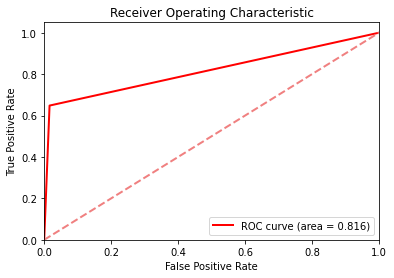

In [27]:
# Evaluating model metrics of Logistic Regression on data imputed with mean values

evaluate_model_metrics(log_reg,X_train,y_train,X_test,y_test)

### Zero Imputation

In [13]:
# Imputing null values with zeroes

X, y, X_train, X_test, y_train, y_test = preprocess_and_split(df = diabetes_df, label = 'Diabetes',
                                                              impute = True, scale=True,
                                                              imputer=SimpleImputer(strategy='constant',fill_value=0),
                                                              random_state=42)


Train Accuracy: 0.929

Test Accuracy: 0.936

Precision: 0.823

Recall: 0.602

F1-Score: 0.695

Confusion Matrix:

[[1535   28]
 [  86  130]]


Classification Report:

              precision    recall  f1-score   support

     Class 0       0.95      0.98      0.96      1563
     Class 1       0.82      0.60      0.70       216

    accuracy                           0.94      1779
   macro avg       0.88      0.79      0.83      1779
weighted avg       0.93      0.94      0.93      1779


ROC-AUC Curve:


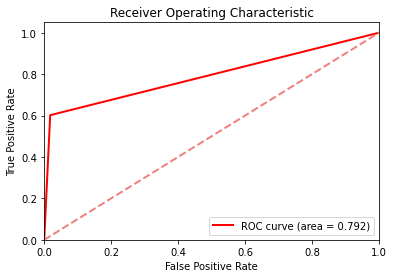

In [14]:
log_reg.fit(X_train, y_train)

evaluate_model_metrics(log_reg,X_train,y_train,X_test,y_test)

### Mode Imputation

In [15]:
# Imputing with most frequent values

X, y, X_train, X_test, y_train, y_test = preprocess_and_split(df = diabetes_df, label = 'Diabetes',
                                                              impute = True, scale=True,
                                                              imputer=SimpleImputer(strategy='most_frequent'),
                                                              random_state=42)


Train Accuracy: 0.936

Test Accuracy: 0.940

Precision: 0.822

Recall: 0.644

F1-Score: 0.722

Confusion Matrix:

[[1533   30]
 [  77  139]]


Classification Report:

              precision    recall  f1-score   support

     Class 0       0.95      0.98      0.97      1563
     Class 1       0.82      0.64      0.72       216

    accuracy                           0.94      1779
   macro avg       0.89      0.81      0.84      1779
weighted avg       0.94      0.94      0.94      1779


ROC-AUC Curve:


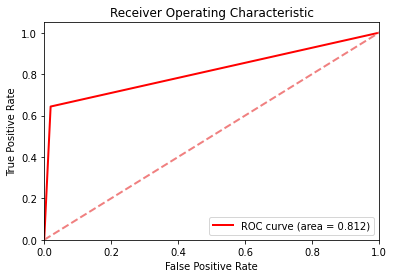

In [16]:
log_reg.fit(X_train, y_train)

evaluate_model_metrics(log_reg,X_train,y_train,X_test,y_test)

### k-NN Imputation

In [17]:
# Imputing missing values with values from the k-nearest neighbors in the feature space

X, y, X_train, X_test, y_train, y_test = preprocess_and_split(df = diabetes_df, label = 'Diabetes',
                                                              impute = True, scale=True,
                                                              imputer=KNNImputer(n_neighbors=20),
                                                              random_state=42)


Train Accuracy: 0.933

Test Accuracy: 0.933

Precision: 0.804

Recall: 0.588

F1-Score: 0.679

Confusion Matrix:

[[1532   31]
 [  89  127]]


Classification Report:

              precision    recall  f1-score   support

     Class 0       0.95      0.98      0.96      1563
     Class 1       0.80      0.59      0.68       216

    accuracy                           0.93      1779
   macro avg       0.87      0.78      0.82      1779
weighted avg       0.93      0.93      0.93      1779


ROC-AUC Curve:


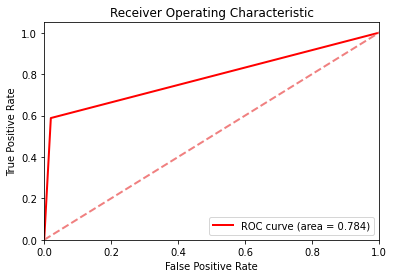

In [18]:
log_reg.fit(X_train, y_train)

evaluate_model_metrics(log_reg,X_train,y_train,X_test,y_test)

### Multiple Imputation by Chained Equations (MICE)

In [20]:
# Imputes by looking at data from other columns and trying to estimate the best prediction for each missing value.

X, y, X_train, X_test, y_train, y_test = preprocess_and_split(df = diabetes_df, label = 'Diabetes',
                                                              impute = True, scale=True,
                                                              imputer=IterativeImputer(max_iter=20),
                                                              random_state=42)


Train Accuracy: 0.931

Test Accuracy: 0.930

Precision: 0.786

Recall: 0.579

F1-Score: 0.667

Confusion Matrix:

[[1529   34]
 [  91  125]]


Classification Report:

              precision    recall  f1-score   support

     Class 0       0.94      0.98      0.96      1563
     Class 1       0.79      0.58      0.67       216

    accuracy                           0.93      1779
   macro avg       0.86      0.78      0.81      1779
weighted avg       0.92      0.93      0.93      1779


ROC-AUC Curve:


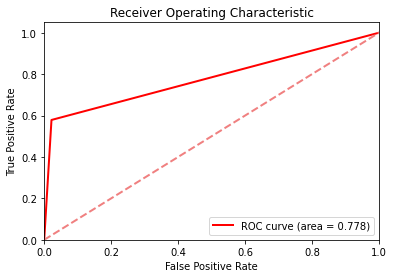

In [21]:
log_reg.fit(X_train, y_train)

evaluate_model_metrics(log_reg,X_train,y_train,X_test,y_test)

### Median Imputation

In [22]:
# Imputing with median values

X, y, X_train, X_test, y_train, y_test = preprocess_and_split(df = diabetes_df, label = 'Diabetes',
                                                              impute = True, scale=True,
                                                              imputer=SimpleImputer(strategy='median'),
                                                              random_state=42)


Train Accuracy: 0.936

Test Accuracy: 0.940

Precision: 0.815

Recall: 0.653

F1-Score: 0.725

Confusion Matrix:

[[1531   32]
 [  75  141]]


Classification Report:

              precision    recall  f1-score   support

     Class 0       0.95      0.98      0.97      1563
     Class 1       0.82      0.65      0.72       216

    accuracy                           0.94      1779
   macro avg       0.88      0.82      0.85      1779
weighted avg       0.94      0.94      0.94      1779


ROC-AUC Curve:


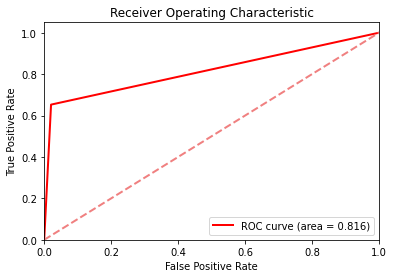

In [23]:
log_reg.fit(X_train, y_train)

evaluate_model_metrics(log_reg,X_train,y_train,X_test,y_test)

### Dropping Null Values

In [24]:
# Drop null values
diabetes_df_na = diabetes_df.dropna()

X, y, X_train, X_test, y_train, y_test = preprocess_and_split(df = diabetes_df_na, label = 'Diabetes',
                                                              impute = False, scale=True,
                                                              random_state=42)


Train Accuracy: 0.920

Test Accuracy: 0.846

Precision: 0.847

Recall: 0.694

F1-Score: 0.763

Confusion Matrix:

[[120   9]
 [ 22  50]]


Classification Report:

              precision    recall  f1-score   support

     Class 0       0.85      0.93      0.89       129
     Class 1       0.85      0.69      0.76        72

    accuracy                           0.85       201
   macro avg       0.85      0.81      0.82       201
weighted avg       0.85      0.85      0.84       201


ROC-AUC Curve:


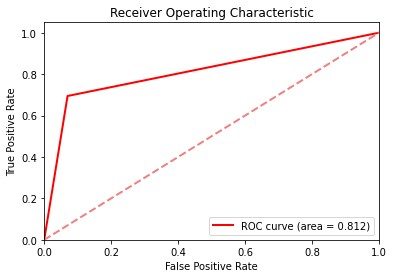

In [25]:
log_reg.fit(X_train, y_train)

evaluate_model_metrics(log_reg,X_train,y_train,X_test,y_test)

## Oversampling and Undersampling

In [26]:
# Class distribution
diabetes_df_na.Diabetes.value_counts()

# Oversampling and undersampling are techniques used to adjust the class distribution of a data set.
# Library -> imblearn

Diabetes
0    668
1    333
Name: count, dtype: int64

### Random Oversampling

In [27]:
# Repeatedly sample instances from the minority class with replacement.

def random_over_sample(X,y, sampling_strategy='auto', random_state=42):
    
    ros = RandomOverSampler(sampling_strategy=sampling_strategy, random_state=random_state)
    X_resampled, y_resampled = ros.fit_resample(X, y)
    
    return X_resampled, y_resampled


Train Accuracy: 0.894

Test Accuracy: 0.846

Precision: 0.797

Recall: 0.764

F1-Score: 0.780

Confusion Matrix:

[[115  14]
 [ 17  55]]


Classification Report:

              precision    recall  f1-score   support

     Class 0       0.87      0.89      0.88       129
     Class 1       0.80      0.76      0.78        72

    accuracy                           0.85       201
   macro avg       0.83      0.83      0.83       201
weighted avg       0.84      0.85      0.85       201


ROC-AUC Curve:


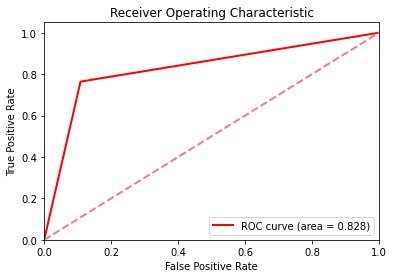

In [28]:
X_ros, y_ros = random_over_sample(X,y)

log_reg.fit(X_ros, y_ros)

evaluate_model_metrics(log_reg,X_ros, y_ros,X_test,y_test)

### SMOTE (Synthetic Minority Over-sampling Technique)

In [29]:
# Generate synthetic examples from the minority class.

def smote_over_sample(X,y, sampling_strategy='auto', random_state=42):
    
    smote = SMOTE(sampling_strategy=sampling_strategy, random_state=random_state)
    X_resampled, y_resampled = smote.fit_resample(X, y)
    
    return X_resampled, y_resampled


Train Accuracy: 0.909

Test Accuracy: 0.881

Precision: 0.853

Recall: 0.806

F1-Score: 0.829

Confusion Matrix:

[[119  10]
 [ 14  58]]


Classification Report:

              precision    recall  f1-score   support

     Class 0       0.89      0.92      0.91       129
     Class 1       0.85      0.81      0.83        72

    accuracy                           0.88       201
   macro avg       0.87      0.86      0.87       201
weighted avg       0.88      0.88      0.88       201


ROC-AUC Curve:


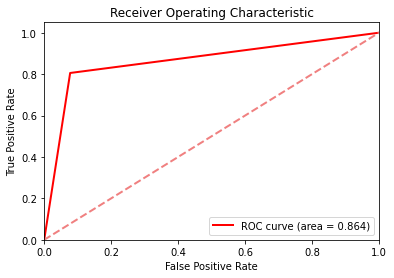

In [30]:
X_smote, y_smote = smote_over_sample(X,y)

log_reg.fit(X_smote, y_smote)

evaluate_model_metrics(log_reg,X_smote, y_smote,X_test,y_test)

### Random Undersampling

In [31]:
# Randomly remove instances from the majority class.

def random_under_sample(X,y, sampling_strategy='auto', random_state=42):
    
    rus = RandomUnderSampler(sampling_strategy=sampling_strategy, random_state=random_state)
    X_resampled, y_resampled = rus.fit_resample(X, y)
    
    return X_resampled, y_resampled


Train Accuracy: 0.884

Test Accuracy: 0.831

Precision: 0.750

Recall: 0.792

F1-Score: 0.770

Confusion Matrix:

[[110  19]
 [ 15  57]]


Classification Report:

              precision    recall  f1-score   support

     Class 0       0.88      0.85      0.87       129
     Class 1       0.75      0.79      0.77        72

    accuracy                           0.83       201
   macro avg       0.81      0.82      0.82       201
weighted avg       0.83      0.83      0.83       201


ROC-AUC Curve:


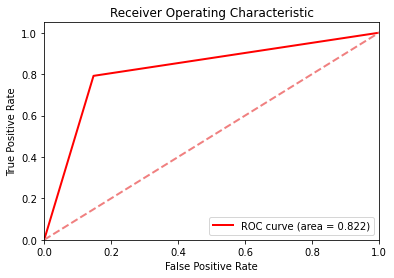

In [32]:
X_rus, y_rus = random_under_sample(X,y)

log_reg.fit(X_rus, y_rus)

evaluate_model_metrics(log_reg,X_rus, y_rus,X_test,y_test)

### Tomek Links

In [33]:
# Identify and remove pairs of instances from different classes that are very close to each other.

def tomek_links(X,y, sampling_strategy='auto', random_state=42):
    
    tl = TomekLinks(sampling_strategy='auto')
    X_resampled, y_resampled = tl.fit_resample(X, y)

    
    return X_resampled, y_resampled


Train Accuracy: 0.910

Test Accuracy: 0.881

Precision: 0.914

Recall: 0.736

F1-Score: 0.815

Confusion Matrix:

[[124   5]
 [ 19  53]]


Classification Report:

              precision    recall  f1-score   support

     Class 0       0.87      0.96      0.91       129
     Class 1       0.91      0.74      0.82        72

    accuracy                           0.88       201
   macro avg       0.89      0.85      0.86       201
weighted avg       0.88      0.88      0.88       201


ROC-AUC Curve:


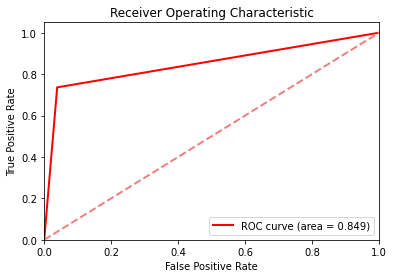

In [34]:
X_tomek, y_tomek = tomek_links(X,y)

log_reg.fit(X_tomek, y_tomek)

evaluate_model_metrics(log_reg,X_tomek, y_tomek,X_test,y_test)

### SMOTE + Tomek Links

In [35]:
# Combine SMOTE for oversampling the minority class with Tomek Links to clean the dataset.

def smote_tomek(X,y, sampling_strategy='auto', random_state=42):
    
    smt = SMOTETomek(sampling_strategy=sampling_strategy, random_state=random_state)
    X_resampled, y_resampled = smt.fit_resample(X, y)
    
    return X_resampled, y_resampled


Train Accuracy: 0.910

Test Accuracy: 0.886

Precision: 0.866

Recall: 0.806

F1-Score: 0.835

Confusion Matrix:

[[120   9]
 [ 14  58]]


Classification Report:

              precision    recall  f1-score   support

     Class 0       0.90      0.93      0.91       129
     Class 1       0.87      0.81      0.83        72

    accuracy                           0.89       201
   macro avg       0.88      0.87      0.87       201
weighted avg       0.88      0.89      0.88       201


ROC-AUC Curve:


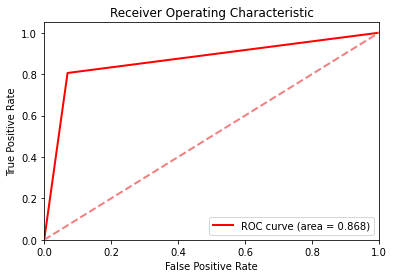

In [36]:
X_smote_tomek, y_smote_tomek = smote_tomek(X,y)

log_reg.fit(X_smote_tomek, y_smote_tomek)

evaluate_model_metrics(log_reg,X_smote_tomek, y_smote_tomek,X_test,y_test)

In [37]:
# Smote + Tomek Links provide better results

X_train, y_train = X_smote_tomek, y_smote_tomek

## Hyperparameter Optimization

In [38]:
# It is the process of finding the right combination of hyperparameter values 
# to achieve maximum performance on the data in a reasonable amount of time

### Grid Search

In [39]:
# Grid search is an exhaustive method to find optimal values for hyperparameters

# Hyperparameters
param_grid = {
    
    'penalty': ['l1', 'l2','none'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'solver': ['newton-cg','saga','lbfgs','liblinear'],
    'max_iter': [100,200,300],
    'class_weight': [None, 'balanced'],
    'warm_start': [False, True],
    
}

In [40]:
grid_search = GridSearchCV(log_reg, param_grid, cv=5, scoring='accuracy', verbose=0, n_jobs=-1)
grid_search.fit(X_train, y_train)

clear_output()     # to clear warnings

In [41]:
# Best hyperparameters
grid_best_params = grid_search.best_params_
grid_best_params

{'C': 0.1,
 'class_weight': None,
 'max_iter': 100,
 'penalty': 'l1',
 'solver': 'liblinear',
 'warm_start': False}

In [42]:
# Model with the best hyperparameters
log_reg_grid = grid_search.best_estimator_


Train Accuracy: 0.900

Test Accuracy: 0.866

Precision: 0.836

Recall: 0.778

F1-Score: 0.806

Confusion Matrix:

[[118  11]
 [ 16  56]]


Classification Report:

              precision    recall  f1-score   support

     Class 0       0.88      0.91      0.90       129
     Class 1       0.84      0.78      0.81        72

    accuracy                           0.87       201
   macro avg       0.86      0.85      0.85       201
weighted avg       0.86      0.87      0.86       201


ROC-AUC Curve:


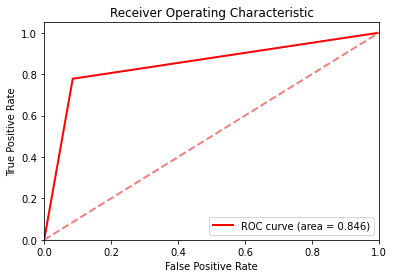

In [43]:
evaluate_model_metrics(log_reg_grid,X_train,y_train,X_test,y_test)

# We can see a slight improvement in some evaluation metrics

In [44]:
# Function to perform grid search optimisation

def grid_search_optimize(model, param_grid, X_train, y_train, cv,
                         scoring='accuracy', verbose=0, n_jobs=-1):
    
    grid_search = GridSearchCV(model, param_grid=param_grid, cv=cv, 
                               scoring=scoring, verbose=verbose, n_jobs=n_jobs)
    
    grid_search.fit(X_train, y_train)
    clear_output()
    
    grid_best_params = grid_search.best_params_
    grid_best_model = grid_search.best_estimator_
    
    return grid_best_params, grid_best_model

### Random Search

In [45]:
# Random Search is faster than grid search due to less iterations performed but it may not be optimal 

random_search = RandomizedSearchCV(
        log_reg,
        param_distributions=param_grid,
        n_iter=100, 
        scoring='accuracy', 
        cv=5, 
        n_jobs=-1, 
        verbose=0
    )

random_search.fit(X_train, y_train)

clear_output()

In [46]:
rand_best_params = random_search.best_params_
rand_best_params

# We get similar hyperparameters

{'warm_start': True,
 'solver': 'liblinear',
 'penalty': 'l1',
 'max_iter': 100,
 'class_weight': 'balanced',
 'C': 0.1}

In [47]:
# Function for Random Search

def random_search_optimize(model,param,n_iter,cv,X_train, y_train,
                           scoring='accuracy', n_jobs=-1, verbose=0):
    
    random_search = RandomizedSearchCV(
        model,
        param_distributions=param,
        n_iter=n_iter, 
        scoring=scoring, 
        cv=cv, 
        n_jobs=n_jobs, 
        verbose=verbose
    )

    random_search.fit(X_train, y_train)
    clear_output()

    rand_best_params = random_search.best_params_
    rand_best_model = random_search.best_estimator_
    
    return rand_best_params, rand_best_model

In [48]:
rand_best_params, log_reg_rand = random_search_optimize(log_reg,param_grid,100,5,X_train, y_train,
                                                            scoring='accuracy', n_jobs=-1, verbose=0)


Train Accuracy: 0.900

Test Accuracy: 0.866

Precision: 0.836

Recall: 0.778

F1-Score: 0.806

Confusion Matrix:

[[118  11]
 [ 16  56]]


Classification Report:

              precision    recall  f1-score   support

     Class 0       0.88      0.91      0.90       129
     Class 1       0.84      0.78      0.81        72

    accuracy                           0.87       201
   macro avg       0.86      0.85      0.85       201
weighted avg       0.86      0.87      0.86       201


ROC-AUC Curve:


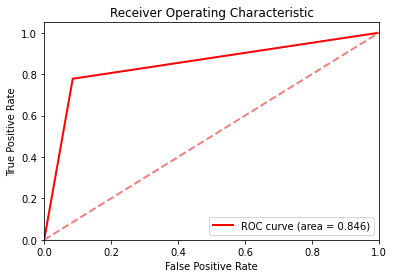

In [49]:
evaluate_model_metrics(log_reg_rand,X_train,y_train,X_test,y_test)

### OPTUNA

In [111]:
# Optuna is an automatic hyperparameter optimization software framework

def objective(trial):
    
    # Hyperparameter search space
    penalty = trial.suggest_categorical('penalty', ['l1', 'l2','none'])
    C = trial.suggest_loguniform('C', 1e-5, 1e5)
    solver = trial.suggest_categorical('solver', ['newton-cg', 'saga', 'lbfgs',
                                                  'liblinear','sag'])
    if (penalty == "l1" and solver not in ["liblinear", "saga"]) or (penalty == "elasticnet" and solver not in ["saga"]) or penalty=='none' and solver in ['liblinear']:
        return 0
    max_iter = trial.suggest_int('max_iter', 100, 300, 500)
    class_weight = trial.suggest_categorical('class_weight', [None, 'balanced'])
    warm_start = trial.suggest_categorical('warm_start', [False, True])
    fit_intercept = trial.suggest_categorical('fit_intercept', [False, True])

    model = LogisticRegression(
        penalty=penalty, C=C, solver=solver, max_iter=max_iter,
        class_weight=class_weight, warm_start=warm_start, fit_intercept=fit_intercept
    )
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)

    return accuracy

In [51]:
def optuna_optimize(n_trials=100,direction='maximum',n_jobs=-1):
    
    study = optuna.create_study(direction='maximize')  # 'maximize' for accuracy, 'minimize' for loss
    study.optimize(objective, n_trials=n_trials, n_jobs=n_jobs)
    clear_output()
    
    best_trial = study.best_trial.params
    log_reg_opt = LogisticRegression(**best_trial)
    
    return best_trial, log_reg_opt

In [52]:
# Best optuna paramaters
best_trial, log_reg_opt = optuna_optimize()

best_trial

{'penalty': 'l2',
 'C': 4.22005726057669,
 'solver': 'newton-cg',
 'max_iter': 100,
 'class_weight': 'balanced',
 'warm_start': False,
 'fit_intercept': True}


Train Accuracy: 0.913

Test Accuracy: 0.886

Precision: 0.855

Recall: 0.819

F1-Score: 0.837

Confusion Matrix:

[[119  10]
 [ 13  59]]


Classification Report:

              precision    recall  f1-score   support

     Class 0       0.90      0.92      0.91       129
     Class 1       0.86      0.82      0.84        72

    accuracy                           0.89       201
   macro avg       0.88      0.87      0.87       201
weighted avg       0.88      0.89      0.89       201


ROC-AUC Curve:


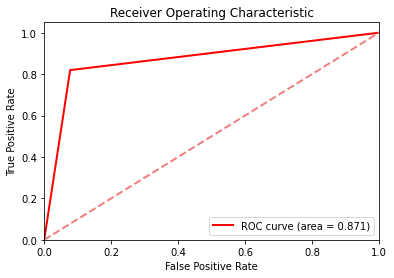

In [53]:
log_reg_opt.fit(X_train,y_train)

evaluate_model_metrics(log_reg_opt,X_train,y_train,X_test,y_test)

# Optuna seems to give good hyperparameters with lesser cost

## Cross Validation

In [54]:
# It is a technique used to evaluate the performance of a model on unseen data.
# It involves dividing the available data into multiple folds or subsets, 
# using one of these folds as a validation set, and training the model on the remaining folds.

### K-fold

In [55]:
# The dataset is divided into k subsets or folds. 
# The model is trained and evaluated k times, using a different fold as the validation set each time. 
# Performance metrics from each fold are averaged to estimate the model's generalization performance.

scores = cross_val_score(log_reg_grid, X, y, cv=10, scoring='accuracy')

print("Scores:", scores)

Scores: [0.9009901 0.92      0.9       0.89      0.91      0.89      0.87
 0.93      0.86      0.86     ]


In [56]:
mean_accuracy = scores.mean()
std_accuracy = scores.std()

print("\nMean Accuracy: ", mean_accuracy)
print("\nStandard Deviation: ", std_accuracy)


Mean Accuracy:  0.89309900990099

Standard Deviation:  0.02285769816185149


In [57]:
def k_cross_validate(model,X,y,cv,scoring='accuracy',n_jobs=-1):
    
    scores = cross_val_score(model, X, y, cv=cv, scoring=scoring)
    
    mean_score = scores.mean()
    std_score = scores.std()
    
    print(f"\n{scoring} scores:", scores)
    print(f"\nMean {scoring} score: ", mean_score)
    print("\nStandard deviation: ", std_score)

In [58]:
k_cross_validate(log_reg,X,y,cv=10,scoring='accuracy',n_jobs=-1)


accuracy scores: [0.89108911 0.91       0.9        0.84       0.9        0.84
 0.83       0.9        0.87       0.83      ]

Mean accuracy score:  0.871108910891089

Standard deviation:  0.031196880743131487


In [59]:
k_cross_validate(log_reg_grid,X,y,cv=10,scoring='accuracy',n_jobs=-1)


accuracy scores: [0.9009901 0.92      0.9       0.89      0.91      0.89      0.87
 0.93      0.86      0.86     ]

Mean accuracy score:  0.89309900990099

Standard deviation:  0.02285769816185149


In [60]:
k_cross_validate(log_reg_opt,X,y,cv=10,scoring='accuracy',n_jobs=-1)


accuracy scores: [0.83168317 0.88       0.9        0.84       0.87       0.83
 0.82       0.87       0.82       0.82      ]

Mean accuracy score:  0.8481683168316831

Standard deviation:  0.02775239753718331


### Stratified K-fold

In [61]:
# Stratified k-fold ensures that each fold maintains the same class distribution as the entire dataset.
# It's useful when dealing with imbalanced datasets, where one class significantly outnumbers the other.

In [62]:
def stratified_k_cross_validate(model,X,y,n_splits,shuffle=True,verbose=0,random_state=42):
    
    X = X.values
    y = y.values

    stratified_kf = StratifiedKFold(n_splits=n_splits, shuffle=shuffle, random_state=random_state)

    scores = []

    # Stratified k-fold cross-validation
    for train_index, test_index in stratified_kf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)

        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        confusion = confusion_matrix(y_test, y_pred)

        scores.append([accuracy,precision,recall,f1,confusion])

        average_accuracy = np.mean([item[0] for item in scores])
        average_precision = np.mean([item[1] for item in scores])
        average_recall = np.mean([item[2] for item in scores])
        average_f1 = np.mean([item[3] for item in scores])

    for fold, score in enumerate(scores, 1):
        if verbose >= 1:
            print(f"Fold {fold}: ")
            print(f"Accuracy: {score[0]:.3f}")
        
        if verbose >= 2:
            print(f"Precision: {score[1]:.3f}")

        if verbose >= 3:
            print(f"Recall: {score[2]:.3f}")

        if verbose >= 4:
            print(f"F1-Score: {score[3]:.3f}")

        if verbose >= 5:
            print(f"Confusion Matrix:\n {score[4]}")
            
        if verbose >= 1:
            print('')

    print(f"\nAverage Accuracy: {average_accuracy}")
    print(f"\nAverage Precision: {average_precision}")
    print(f"\nAverage Recall: {average_recall}")
    print(f"\nAverage F1-Score: {average_f1}")

In [63]:
stratified_k_cross_validate(log_reg,X,y,n_splits=10,verbose=4)

Fold 1: 
Accuracy: 0.881
Precision: 0.824
Recall: 0.824
F1-Score: 0.824

Fold 2: 
Accuracy: 0.880
Precision: 0.839
Recall: 0.788
F1-Score: 0.812

Fold 3: 
Accuracy: 0.870
Precision: 0.857
Recall: 0.727
F1-Score: 0.787

Fold 4: 
Accuracy: 0.850
Precision: 0.765
Recall: 0.788
F1-Score: 0.776

Fold 5: 
Accuracy: 0.910
Precision: 0.900
Recall: 0.818
F1-Score: 0.857

Fold 6: 
Accuracy: 0.840
Precision: 0.815
Recall: 0.667
F1-Score: 0.733

Fold 7: 
Accuracy: 0.890
Precision: 1.000
Recall: 0.667
F1-Score: 0.800

Fold 8: 
Accuracy: 0.840
Precision: 0.815
Recall: 0.667
F1-Score: 0.733

Fold 9: 
Accuracy: 0.850
Precision: 0.806
Recall: 0.735
F1-Score: 0.769

Fold 10: 
Accuracy: 0.820
Precision: 0.786
Recall: 0.647
F1-Score: 0.710


Average Accuracy: 0.8631188118811881

Average Precision: 0.8405883356927001

Average Recall: 0.7327094474153298

Average F1-Score: 0.7801751773046552


In [64]:
stratified_k_cross_validate(log_reg_grid,X,y,n_splits=10,verbose=1)

Fold 1: 
Accuracy: 0.901

Fold 2: 
Accuracy: 0.910

Fold 3: 
Accuracy: 0.900

Fold 4: 
Accuracy: 0.950

Fold 5: 
Accuracy: 0.940

Fold 6: 
Accuracy: 0.870

Fold 7: 
Accuracy: 0.870

Fold 8: 
Accuracy: 0.880

Fold 9: 
Accuracy: 0.880

Fold 10: 
Accuracy: 0.850


Average Accuracy: 0.8950990099009901

Average Precision: 0.9162876418933392

Average Recall: 0.7540106951871658

Average F1-Score: 0.8256531166360421


In [65]:
stratified_k_cross_validate(log_reg_opt,X,y,n_splits=10)


Average Accuracy: 0.8441683168316831

Average Precision: 0.7577817101675509

Average Recall: 0.7897504456327986

Average F1-Score: 0.7713192367052291


## Feature Selection

In [66]:
# Using all the features to train the model may result in overfitting
# This can be avoided by performing feature extraction
# We can use a combination of various methods along with domain knowledge to select the features
# As we shall see, most of the insights derived from these methods seem to be in agreement with current research

### Correlation Analysis

In [67]:
# Function to check which features are more correlated with the disease

def get_correlated_features(df,disease,pos,neg):
    
    corr_df = df.corr()[disease].sort_values(ascending=False)
    pos_corr = corr_df[corr_df>pos]
    neg_corr = corr_df[corr_df<neg]
    
    return pos_corr, neg_corr

In [68]:
pos_corr, neg_corr = get_correlated_features(diabetes_df,'Diabetes',pos=0.1,neg=-0.1)

print('Positive Correlation\n\n',pos_corr,sep='')
print('\n\nNegative Correlation\n\n',neg_corr,sep='')

Positive Correlation

Diabetes                              1.000000
Glycohemoglobin [%]                   0.616415
Fasting Glucose [mmol/L]              0.610611
Age                                   0.396039
BMI                                   0.269706
Blood Urea Nitrogen [mg/dL]           0.242561
Insulin [pmol/L]                      0.234273
Osmolality [mmol/Kg]                  0.224238
Retinol [umol/L]                      0.213473
Triglyceride [mmol/L]                 0.167136
Alpha-tocopherol [umol/L]             0.162476
Triglyceride_HDL Ratio                0.156951
Segmented neutrophils [%]             0.153802
Neutrophil_Lymphocyte Ratio           0.147970
C-Reactive Protein [mg/L]             0.137446
Creatinine [mg/dL]                    0.132612
Ferritin [ng/mL]                      0.130874
Red cell distribution width [%]       0.124067
25-hydroxyvitamin D2 + D3 [nmol/L]    0.104823
Total Cholestrol_HDL Ratio            0.104507
Mean platelet volume [fL]             

In [69]:
# Evaluating the performance of a model on the selected features for comparison

corr_features = ['Gender'] + list(pos_corr.keys()[1:10]) + list(neg_corr.keys()[:10]) 

log_reg_test = LogisticRegression()

In [70]:
def evaluate_feature_set(feature_set, model, X_train,y_train,X_test,y_test):
    
    X_train = X_train[feature_set]
    X_test = X_test[feature_set]

    model.fit(X_train, y_train)

    evaluate_model_metrics(model,X_train,y_train,X_test,y_test)


Train Accuracy: 0.885

Test Accuracy: 0.831

Precision: 0.771

Recall: 0.750

F1-Score: 0.761

Confusion Matrix:

[[113  16]
 [ 18  54]]


Classification Report:

              precision    recall  f1-score   support

     Class 0       0.86      0.88      0.87       129
     Class 1       0.77      0.75      0.76        72

    accuracy                           0.83       201
   macro avg       0.82      0.81      0.81       201
weighted avg       0.83      0.83      0.83       201


ROC-AUC Curve:


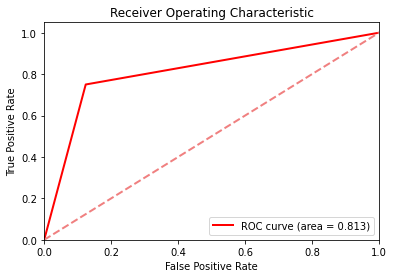

In [71]:
evaluate_feature_set(corr_features,log_reg_test,X_train,y_train,X_test,y_test)

### Select From Model

In [72]:
# SelectFromModel can be used with any estimator that exposes feature importance

def select_from_model_features(model,X,y):

    sfm = SelectFromModel(model)  

    
    sfm.fit_transform(X, y)

    
    selected_features = sfm.get_support()
    feature_names = X.columns
    sfm_features = [feature_names[i] for i, selected in enumerate(selected_features) if selected]

    return sfm_features

In [73]:
sfm_features = select_from_model_features(log_reg,X,y)
sfm_features

['Gender',
 'BMI',
 'A/G Ratio',
 'Basophils [%]',
 'Cis-beta-carotene [umol/L]',
 'Fasting Glucose [mmol/L]',
 'Glycohemoglobin [%]',
 'Iron [ug/dL]',
 'Iron frozen [umol/L]',
 'Mean cell volume [fL]',
 'Neutrophil_Lymphocyte Ratio',
 'Osmolality [mmol/Kg]',
 'Potassium [mmol/L]',
 'RBC count [million cells/uL]',
 'Retinol [umol/L]',
 'Retinyl palmitate [umol/L]',
 'Sodium [mmol/L]',
 'Systemic Immune‐inflammation Index (SII)',
 'Total Cholestrol_HDL Ratio',
 'Trans-beta-carotene [umol/L]',
 'Triglyceride_HDL Ratio',
 'Chloride [mmol/L]',
 'Hemoglobin [g/dL]',
 'LDL-Cholesterol(NIH2) [mmol/L]',
 'Transferrin Saturation [%]',
 'Triglyceride [mmol/L]']


Train Accuracy: 0.898

Test Accuracy: 0.866

Precision: 0.826

Recall: 0.792

F1-Score: 0.809

Confusion Matrix:

[[117  12]
 [ 15  57]]


Classification Report:

              precision    recall  f1-score   support

     Class 0       0.89      0.91      0.90       129
     Class 1       0.83      0.79      0.81        72

    accuracy                           0.87       201
   macro avg       0.86      0.85      0.85       201
weighted avg       0.86      0.87      0.87       201


ROC-AUC Curve:


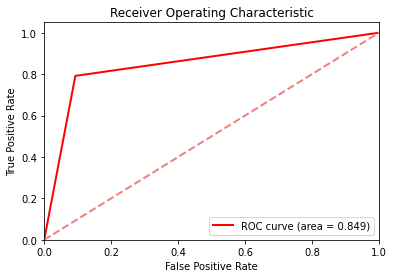

In [74]:
sfm_features = list(sfm_features) 

evaluate_feature_set(sfm_features,log_reg_test,X_train,y_train,X_test,y_test)

### SelectKBest

In [75]:
# Function to select features using SelectKBest using anova scores

def select_k_best(X,y,n):
    
    select = SelectKBest(score_func = f_classif, k = n)
    
    z = select.fit_transform(X,y)

    feature_rankings = select.scores_
    feature_rankings_df = pd.DataFrame({'Feature': X.columns, 'Ranking': feature_rankings})
    sorted_features = feature_rankings_df.sort_values(by='Ranking',ascending=False)
    
    return sorted_features.Feature.values

In [76]:
k_best_features = select_k_best(X, y, n=30)
k_best_features[:30]

array(['Glycohemoglobin [%]', 'Fasting Glucose [mmol/L]',
       'Osmolality [mmol/Kg]', 'Direct HDL-Cholesterol [mmol/L]',
       'Total Cholesterol [mmol/L]', 'Insulin [pmol/L]',
       'Blood Urea Nitrogen [mg/dL]', 'BMI',
       'LDL-Cholesterol(NIH2) [mmol/L]', 'Chloride [mmol/L]', 'Age',
       'Triglyceride_HDL Ratio', 'Platelet_WBC Ratio',
       'Triglyceride [mmol/L]', 'Non_HDL Ratio', 'Retinol [umol/L]',
       'Alpha-crypotoxanthin [umol/L]', 'Ferritin [ng/mL]',
       'Trans-beta-carotene [umol/L]', 'Cis-beta-carotene [umol/L]',
       'Transferrin Saturation [%]',
       'White blood cell count [1000 cells/uL]', 'UIBC [umol/L]',
       'Alanine Aminotransferase [U/L]', 'Total Lycopene [umol/L]',
       'Creatinine [mg/dL]', 'Iron frozen [umol/L]',
       'Trans-lycopene [umol/L]', 'Iron [ug/dL]',
       'Alpha-carotene [umol/L]'], dtype=object)


Train Accuracy: 0.892

Test Accuracy: 0.856

Precision: 0.821

Recall: 0.764

F1-Score: 0.791

Confusion Matrix:

[[117  12]
 [ 17  55]]


Classification Report:

              precision    recall  f1-score   support

     Class 0       0.87      0.91      0.89       129
     Class 1       0.82      0.76      0.79        72

    accuracy                           0.86       201
   macro avg       0.85      0.84      0.84       201
weighted avg       0.85      0.86      0.85       201


ROC-AUC Curve:


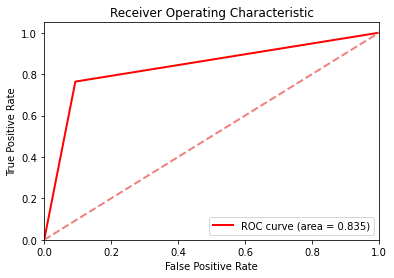

In [77]:
k_best_features_ = list(k_best_features[:18]) 

evaluate_feature_set(k_best_features_,log_reg_test,X_train,y_train,X_test,y_test)

### Recursive Feature Elimination (RFE) 

In [78]:
#  RFE is a method that recursively removes the least important features from the dataset

def select_rfe_features(model,X,y,n,step):
    
    rfe = RFE(model,n_features_to_select=n,step=step)
    fit = rfe.fit(X, y)

    feature_rankings = rfe.ranking_
    feature_rankings_df = pd.DataFrame({'Feature': X.columns, 'Ranking': feature_rankings})
    sorted_features = feature_rankings_df.sort_values(by='Ranking')
    
    return sorted_features.Feature.values

In [79]:
rfe_features = select_rfe_features(log_reg,X,y,n=30,step=0.2)
rfe_features[:30]

array(['Gender', 'Iron [ug/dL]', 'Iron frozen [umol/L]',
       'Lutein and zeaxanthin [umol/L]', 'Mean cell volume [fL]',
       'Neutrophil_Lymphocyte Ratio', 'Osmolality [mmol/Kg]',
       'Potassium [mmol/L]', 'RBC count [million cells/uL]',
       'Retinol [umol/L]', 'Retinyl palmitate [umol/L]',
       'Sodium [mmol/L]', 'Systemic Immune‐inflammation Index (SII)',
       'Trans-beta-carotene [umol/L]', 'Triglyceride_HDL Ratio',
       'Uric Acid [mg/dL]', 'Chloride [mmol/L]', 'Hemoglobin [g/dL]',
       'Insulin [pmol/L]', 'LDL-Cholesterol(NIH2) [mmol/L]',
       'Lactate Dehydrogenase [IU/L]', 'Transferrin Saturation [%]',
       'Glycohemoglobin [%]', 'Globulin [g/dL]', 'Triglyceride [mmol/L]',
       'Fasting Glucose [mmol/L]', 'BMI', 'Basophils [%]', 'A/G Ratio',
       'Cis-beta-carotene [umol/L]'], dtype=object)


Train Accuracy: 0.900

Test Accuracy: 0.871

Precision: 0.819

Recall: 0.819

F1-Score: 0.819

Confusion Matrix:

[[116  13]
 [ 13  59]]


Classification Report:

              precision    recall  f1-score   support

     Class 0       0.90      0.90      0.90       129
     Class 1       0.82      0.82      0.82        72

    accuracy                           0.87       201
   macro avg       0.86      0.86      0.86       201
weighted avg       0.87      0.87      0.87       201


ROC-AUC Curve:


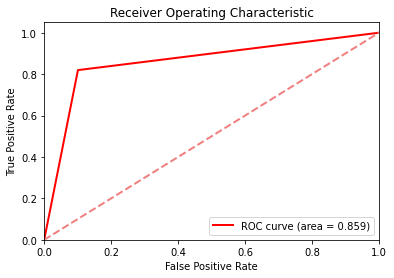

In [80]:
rfe_features_ = list(rfe_features[:30]) 

evaluate_feature_set(rfe_features_,log_reg_test,X_train,y_train,X_test,y_test)

### Lasso Regularization

In [81]:
# Uses lasso regularization to give more weights to more important features

def log_reg_lasso_select(X_train,y_train,solver='saga'):
    l1_reg_model = LogisticRegression(penalty='l1', solver=solver)
    l1_reg_model.fit(X_train, y_train)

    # Get feature importance coefficients from the model
    feature_importance = l1_reg_model.coef_[0]

    feature_importance_pairs = [(feature, importance) for feature, importance in zip(X.columns, feature_importance)]
    feature_importance_pairs.sort(key=lambda x: abs(x[1]), reverse=True)

    l1_sorted_features = [feature for feature, _ in feature_importance_pairs]

    return l1_sorted_features

In [82]:
l1_selected_features = log_reg_lasso_select(X_train,y_train)
l1_selected_features[:30]

['Fasting Glucose [mmol/L]',
 'Glycohemoglobin [%]',
 'Osmolality [mmol/Kg]',
 'Cis-beta-carotene [umol/L]',
 'Gender',
 'Sodium [mmol/L]',
 'Retinyl palmitate [umol/L]',
 'Chloride [mmol/L]',
 'Transferrin Saturation [%]',
 'BMI',
 'Basophils [%]',
 'Potassium [mmol/L]',
 'Trans-beta-carotene [umol/L]',
 'Uric Acid [mg/dL]',
 'Aspartate Aminotransferase [U/L]',
 'Insulin [pmol/L]',
 'A/G Ratio',
 'Lactate Dehydrogenase [IU/L]',
 'LDL-Cholesterol(NIH2) [mmol/L]',
 'Total Protein [g/dL]',
 'Bicarbonate [mmol/L]',
 'Creatine Phosphokinase [IU/L]',
 'Retinol [umol/L]',
 'Blood cadmium [nmol/L]',
 'C-Reactive Protein [mg/L]',
 'Transferrin receptor [nmol/L]',
 'Non_HDL Ratio',
 'Total Cholestrol_HDL Ratio',
 'Direct HDL-Cholesterol [mmol/L]',
 'Platelet count [1000 cells/uL]']


Train Accuracy: 0.902

Test Accuracy: 0.871

Precision: 0.829

Recall: 0.806

F1-Score: 0.817

Confusion Matrix:

[[117  12]
 [ 14  58]]


Classification Report:

              precision    recall  f1-score   support

     Class 0       0.89      0.91      0.90       129
     Class 1       0.83      0.81      0.82        72

    accuracy                           0.87       201
   macro avg       0.86      0.86      0.86       201
weighted avg       0.87      0.87      0.87       201


ROC-AUC Curve:


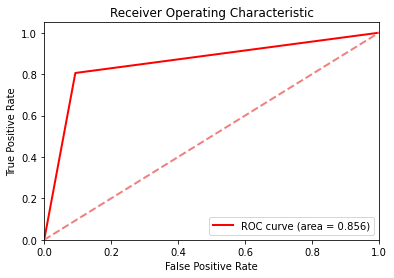

In [83]:
l1_selected_features_ = list(l1_selected_features[:30])

evaluate_feature_set(l1_selected_features_,log_reg_test,X_train,y_train,X_test,y_test)

### Relief F

In [84]:
# It focuses on selecting features that are relevant to the target class

def relief_feature_select(n,X,y,n_jobs=-1):
    
    fs = ReliefF(n_features_to_select=n, n_jobs=n_jobs)
    fs.fit(X.values, y.values)

    feature_importances = fs.feature_importances_
    
    feature_names = X.columns
    feature_importance_tuples = list(zip(feature_names, feature_importances))
    sorted_features = sorted(feature_importance_tuples, key=lambda x: x[1], reverse=True)
    sorted_feature_names = [feature[0] for feature in sorted_features]
    relieff_features = sorted_feature_names
    
    return relieff_features

In [85]:
relieff_features = relief_feature_select(30,X,y)

In [86]:
relieff_features_ = relieff_features[:30]
relieff_features_

['Glycohemoglobin [%]',
 'Fasting Glucose [mmol/L]',
 'Total Cholesterol [mmol/L]',
 'LDL-Cholesterol(NIH2) [mmol/L]',
 'Triglyceride_HDL Ratio',
 'BMI',
 'Blood Urea Nitrogen [mg/dL]',
 'Nucleated RBCs',
 'Non_HDL Ratio',
 'Triglyceride [mmol/L]',
 'Age',
 'Osmolality [mmol/Kg]',
 'Insulin [pmol/L]',
 'Direct HDL-Cholesterol [mmol/L]',
 'Hemoglobin [g/dL]',
 'Hematocrit [%]',
 'RBC count [million cells/uL]',
 'Retinol [umol/L]',
 'Chloride [mmol/L]',
 'LDL_HDL Ratio',
 'Alanine Aminotransferase [U/L]',
 'Total Cholestrol_HDL Ratio',
 'UIBC [umol/L]',
 'Gender',
 'Alpha-tocopherol [umol/L]',
 'Uric Acid [mg/dL]',
 'Total Calcium [mg/dL]',
 '25-hydroxyvitamin D2 + D3 [nmol/L]',
 'Aspartate Aminotransferase [U/L]',
 'Ferritin [ng/mL]']


Train Accuracy: 0.892

Test Accuracy: 0.836

Precision: 0.775

Recall: 0.764

F1-Score: 0.769

Confusion Matrix:

[[113  16]
 [ 17  55]]


Classification Report:

              precision    recall  f1-score   support

     Class 0       0.87      0.88      0.87       129
     Class 1       0.77      0.76      0.77        72

    accuracy                           0.84       201
   macro avg       0.82      0.82      0.82       201
weighted avg       0.84      0.84      0.84       201


ROC-AUC Curve:


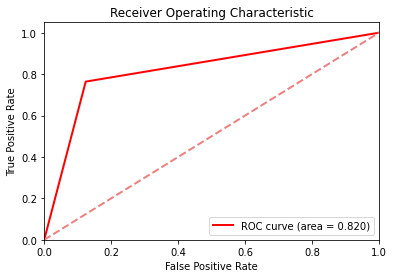

In [87]:
evaluate_feature_set(relieff_features_,log_reg_test,X_train,y_train,X_test,y_test)

### Ensemble of Feature Sets

In [88]:
# We can also create a feature set from the above sets by selecting commonly occuring features

list1 = list(corr_features)
list2 = list(k_best_features_)
list3 = list(sfm_features)
list4 = list(rfe_features_)
list5 = list(l1_selected_features_)
list6 = list(relieff_features_)

combined_list = list1 + list2 + list3 + list4 + list5 + list6
feature_counts = Counter(combined_list)
min_count = 3

combined_features = [feature for feature, count in feature_counts.items() if count >= min_count]
combined_features

['Gender',
 'Glycohemoglobin [%]',
 'Fasting Glucose [mmol/L]',
 'Age',
 'BMI',
 'Blood Urea Nitrogen [mg/dL]',
 'Insulin [pmol/L]',
 'Osmolality [mmol/Kg]',
 'Retinol [umol/L]',
 'Triglyceride [mmol/L]',
 'A/G Ratio',
 'Chloride [mmol/L]',
 'Direct HDL-Cholesterol [mmol/L]',
 'LDL-Cholesterol(NIH2) [mmol/L]',
 'Triglyceride_HDL Ratio',
 'Non_HDL Ratio',
 'Basophils [%]',
 'Cis-beta-carotene [umol/L]',
 'Potassium [mmol/L]',
 'RBC count [million cells/uL]',
 'Retinyl palmitate [umol/L]',
 'Sodium [mmol/L]',
 'Total Cholestrol_HDL Ratio',
 'Trans-beta-carotene [umol/L]',
 'Hemoglobin [g/dL]',
 'Transferrin Saturation [%]',
 'Uric Acid [mg/dL]']


Train Accuracy: 0.893

Test Accuracy: 0.856

Precision: 0.821

Recall: 0.764

F1-Score: 0.791

Confusion Matrix:

[[117  12]
 [ 17  55]]


Classification Report:

              precision    recall  f1-score   support

     Class 0       0.87      0.91      0.89       129
     Class 1       0.82      0.76      0.79        72

    accuracy                           0.86       201
   macro avg       0.85      0.84      0.84       201
weighted avg       0.85      0.86      0.85       201


ROC-AUC Curve:


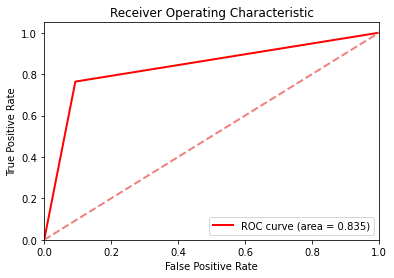

In [89]:
evaluate_feature_set(combined_features,log_reg_test,X_train,y_train,X_test,y_test)

In [94]:
# Now let us find out the optimal number of features to use for training
# By evaluating the model on increasing number of features, we can obtain the optimal number of features

def plot_num_feature_performance(model, X_train, X_test, y_train, y_test, feature_set,
                                 cv=10, scoring='accuracy', verbose=False):
    
    X_train = X_train[feature_set]
    X_test = X_test[feature_set]
            
    num_features = []
    accuracies = []
    num_features_vs_accuracy = {}

    num_features_list = []
    accuracy_list = []

    # Evaluating the model for each set of number of features
    for num_features in range(5, X_train.shape[1] + 1):

        X_train_subset = X_train.iloc[:, :num_features]
        X_test_subset = X_test.iloc[:, :num_features]

        clf = LogisticRegression()
        clf.fit(X_train_subset, y_train)

        y_pred = clf.predict(X_test_subset)
    
        if scoring == 'accuracy':
            score = accuracy_score(y_test, y_pred)
        elif scoring == 'precision':
            score = precision_score(y_test, y_pred)
        elif scoring == 'recall':
            score = recall_score(y_test, y_pred)
        elif scoring == 'f1':
            score = f1_score(y_test, y_pred)
        elif scoring == 'auc':
            fpr, tpr, thresholds = roc_curve(y_test, y_pred)
            score = auc(fpr, tpr)

        num_features_list.append(num_features)
        accuracy_list.append(score)
        
        if verbose == True:
            print(num_features, ':', score)
        num_features_vs_accuracy[num_features] = score
    
    max_score = max(num_features_vs_accuracy.values())
    max_score_num_feature = [i for i in num_features_vs_accuracy if num_features_vs_accuracy[i]==max_score]
    print(f'\nMaximum {scoring} = {max_score} for {max_score_num_feature[0]} features')

    plt.figure(figsize=(10,7))
    plt.plot(num_features_list, accuracy_list, marker='o', color='red', linestyle='-')
    plt.title('Model Performance vs. Number of Features')
    plt.xlabel('Number of Features')
    plt.ylabel('Accuracy')
    plt.show()


Maximum accuracy = 0.8905472636815921 for 79 features


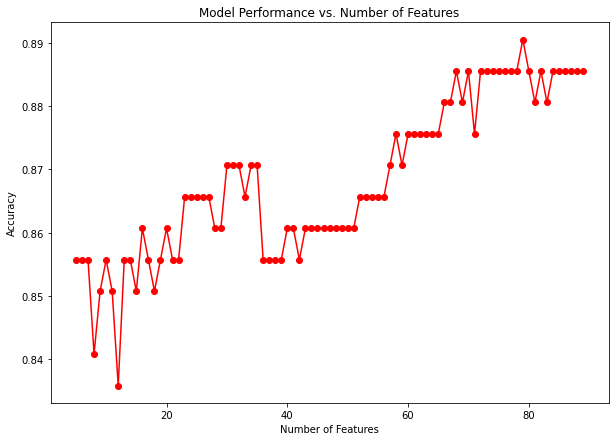

In [95]:
final_features = list(l1_selected_features) 

plot_num_feature_performance(log_reg, X_train, X_test, y_train, y_test, final_features)


Train Accuracy: 0.911

Test Accuracy: 0.891

Precision: 0.879

Recall: 0.806

F1-Score: 0.841

Confusion Matrix:

[[121   8]
 [ 14  58]]


Classification Report:

              precision    recall  f1-score   support

     Class 0       0.90      0.94      0.92       129
     Class 1       0.88      0.81      0.84        72

    accuracy                           0.89       201
   macro avg       0.89      0.87      0.88       201
weighted avg       0.89      0.89      0.89       201


ROC-AUC Curve:


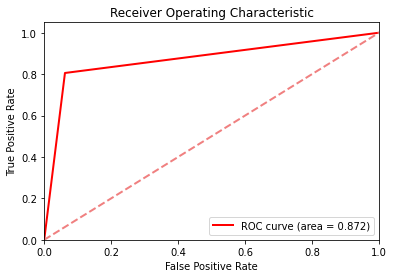

In [108]:
selected = l1_selected_features[:79]

X_train = X_train[selected]
X_test = X_test[selected]

log_reg.fit(X_train, y_train)

evaluate_model_metrics(log_reg, X_train, y_train, X_test, y_test)

In [112]:
# Performing hyperparameter optimisation on the new dataset and model (using Optuna)

best_trial, log_reg_opt = optuna_optimize()

best_trial

{'penalty': 'l2',
 'C': 1.3285893952553847,
 'solver': 'newton-cg',
 'max_iter': 100,
 'class_weight': None,
 'warm_start': False,
 'fit_intercept': False}


Train Accuracy: 0.908

Test Accuracy: 0.886

Precision: 0.877

Recall: 0.792

F1-Score: 0.832

Confusion Matrix:

[[121   8]
 [ 15  57]]


Classification Report:

              precision    recall  f1-score   support

     Class 0       0.89      0.94      0.91       129
     Class 1       0.88      0.79      0.83        72

    accuracy                           0.89       201
   macro avg       0.88      0.86      0.87       201
weighted avg       0.89      0.89      0.88       201


ROC-AUC Curve:


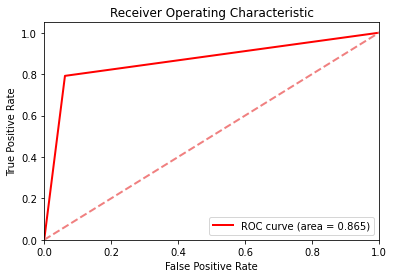

In [113]:
log_reg_opt.fit(X_train, y_train)

evaluate_model_metrics(log_reg_opt,X_train,y_train,X_test,y_test)

In [114]:
# Now to evaluate further, we use cross-validation

k_cross_validate(log_reg,X,y,cv=10,scoring='accuracy')


accuracy scores: [0.89108911 0.91       0.9        0.84       0.9        0.84
 0.83       0.9        0.87       0.83      ]

Mean accuracy score:  0.871108910891089

Standard deviation:  0.031196880743131487


In [115]:
k_cross_validate(log_reg_opt,X,y,cv=10,scoring='accuracy')


accuracy scores: [0.88118812 0.9        0.9        0.84       0.9        0.86
 0.86       0.9        0.88       0.83      ]

Mean accuracy score:  0.875118811881188

Standard deviation:  0.02502628948086163


In [116]:
stratified_k_cross_validate(log_reg,X,y,n_splits=10,random_state=42)


Average Accuracy: 0.8631188118811881

Average Precision: 0.8405883356927001

Average Recall: 0.7327094474153298

Average F1-Score: 0.7801751773046552


In [117]:
stratified_k_cross_validate(log_reg_opt,X,y,n_splits=10,random_state=42)

# We observe that our model is consistent


Average Accuracy: 0.8681089108910891

Average Precision: 0.8413031899454314

Average Recall: 0.7507130124777184

Average F1-Score: 0.7902841307923418


In [118]:
final_log_reg_estimator = log_reg_opt